In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from nltk.corpus import stopwords
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import _pickle as cPickle
import emoji
import nltk
import re

import matplotlib.pyplot as mp
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from insultFunctions import *

#-----Read in data-----#
annotations = pd.read_csv('/Users/degravek/DataScience/SafeSocial/data/perspectives/' + \
                                                    'attack_annotations.tsv', sep='\t')
labels = annotations.groupby('rev_id')['attack'].mean()

df = pd.read_csv('/Users/degravek/DataScience/SafeSocial/data/perspectives/' + \
                                                'attack_annotated_comments.tsv', sep='\t')
df['attack'] = labels.values
df.loc[df['attack'] > 0.5, 'attack'] = 1
df.loc[df['attack'] <= 0.5, 'attack'] = 0

df = df[['comment', 'attack','split']]

In [2]:
df['comment'] = df['comment'].apply(preProcess)

df = df[df['comment'] != '']

#df['numExcQue'] = df['comment'].apply(numExcQue)
#df['ratioCaps'] = df['comment'].apply(ratioCaps)
#df['textPro'] = df['comment'].apply(replaceYou)
#df['textPro'] = df['textPro'].apply(replaceBad)
#df['textPro'] = df['textPro'].apply(replaceCont)
df['textPro'] = df['comment'].apply(replaceMultPunc)
df['textPro'] = df['textPro'].apply(processTextInsult)

df = df[df['comment'] != '']

#df['numDirect'] = df['textPro'].apply(numDirect)
#df['ratioBadWords'] = df['textPro'].apply(ratioBadWords)

In [84]:
df.head()

,comment,attack,split,textPro
0,`- this is not ``creative``. those are the dic...,0.0,train,this is not creative those are the dictionary ...
1,` :: the term ``standard model`` is itself les...,0.0,train,the term standard model is itself less npov th...
2,"true or false, the situation as of march 2002 ...",0.0,train,true or false the situation as of march 2002 w...
3,"next, maybe you could work on being less conde...",0.0,dev,next maybe you could work on being less condes...
4,this page will need disambiguation.,0.0,train,this page will need disambiguation


In [3]:
df = df.sample(frac=1, random_state=0)

df_train = df[df['attack']==1][:10000].append(df[df['attack']==0][:10000])
df_test = df[df['attack']==1][10000:].append(df[df['attack']==0][10000:])

y_train = df_train['attack'].values
y_test = df_test['attack'].values

df_train.drop(['attack','split'], axis=1, inplace=True)
df_test.drop(['attack','split'], axis=1, inplace=True)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [4]:
param_grid = [{'tvec__ngram_range': [(1,1), (3,3)],
                'tvec__stop_words': ['english', None],
                'tvec__max_features': [500, None],
                'tvec__use_idf': [True, False],
                'tvec__analyzer': ['word', 'char'],
                'clf__penalty': ['l2']}]

tvec = TfidfVectorizer(strip_accents='unicode', norm=None)

pipeline = Pipeline([('DCE1', ItemSelector('textPro')), ('tvec', tvec),
                    ('clf', LogisticRegression())])

grid_cv = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, verbose=5)
grid_cv.fit(df_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.82325, total=   2.3s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.827, total=   2.3s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.82575, total=   2.2s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.82825, total=   2.4s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.4s remaining:    0.0s


[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=True, score=0.8205, total=   3.4s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.82275, total=   2.3s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.82725, total=   2.2s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec

[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.58475, total=   4.7s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.582, total=   4.9s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.5915, total=   6.7s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=500, tvec__ngram_range=(3, 3), tve

[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.8725, total=   3.9s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.87425, total=   3.8s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.56475, total=  22.5s
[CV] clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=word, tvec__max_features=None, tvec__ng

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.7255, total=   2.4s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.71375, total=   2.6s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False, score=0.71875, total=   2.5s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(1, 1), tvec__stop_words=english, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tve

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.82, total=   7.3s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.8145, total=   7.1s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=True, score=0.82375, total=   7.8s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tvec__stop_words=None, tvec__use_idf=False 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=500, tvec__ngram_range=(3, 3), tve

[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(1, 1), tvec__stop_words=None, tvec__use_idf=False, score=0.71725, total=   2.4s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.86, total=  11.9s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True, score=0.8475, total=  12.4s
[CV] clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__ngram_range=(3, 3), tvec__stop_words=english, tvec__use_idf=True 
[CV]  clf__penalty=l2, tvec__analyzer=char, tvec__max_features=None, tvec__n

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 25.8min finished


{'clf__penalty': 'l2', 'tvec__analyzer': 'word', 'tvec__max_features': None, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None, 'tvec__use_idf': False}
0.8765


In [14]:
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                       max_features=None, norm=None, stop_words=None, use_idf=False)

X_train = tvec.fit_transform(df_train['textPro'])
X_test = tvec.transform(df_test['textPro'])

param_grid = [{'alpha': 10**np.linspace(-6, -1, 20)}]
grid_cv = GridSearchCV(SGDClassifier(loss='log', penalty='l2', max_iter=1000),
                                    param_grid, scoring='neg_log_loss', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.4min finished


{'alpha': 0.00023357214690901214}
-0.362903611002


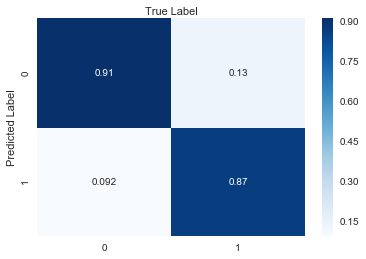

In [15]:
import matplotlib.pyplot as mp

predict = grid_cv.predict(X_test)
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')
mp.show()

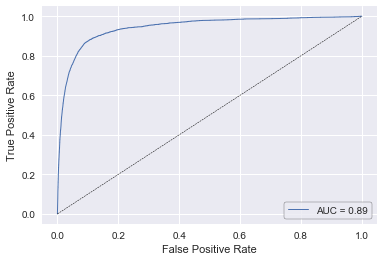

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, grid_cv.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=0.5)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

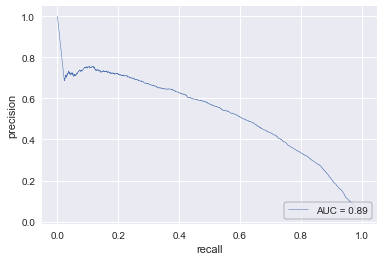

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, grid_cv.predict_proba(X_test)[:,1])

auc(recall, precision)

mp.plot(recall, precision, lw=0.5, label='AUC = %0.2f'%(roc_auc))
mp.xlabel('recall')
mp.ylabel('precision')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
mp.show()

In [18]:
tvec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=False,
        vocabulary=None)

In [19]:
model = SGDClassifier(alpha=0.00023357214690901214, loss='log', penalty='l2', max_iter=1000)
model.fit(X_train, y_train)

SGDClassifier(alpha=0.00023357214690901214, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [20]:
dest = '/Users/degravek/DataScience/SafeSocial/application/pkl_objects_8172017/'

cPickle.dump(model, open(os.path.join(dest, 'model_insult.pkl'), 'wb'), protocol=None)
cPickle.dump(tvec, open(os.path.join(dest, 'tvec_insult.pkl'), 'wb'), protocol=None)

In [21]:
text = "@realDonaldTrump You are actually a disgusting excuse of a President and we would love to have @BarackObama back, also you have tiny hands"

dnew = pd.DataFrame([text], columns=['comment'])
#dnew['numExcQue'] = dnew['comment'].apply(numExcQue)
#dnew['ratioCaps'] = dnew['comment'].apply(ratioCaps)
#dnew['textPro'] = dnew['comment'].apply(replaceYou)
#dnew['textPro'] = dnew['textPro'].apply(replaceBad)
#dnew['textPro'] = dnew['textPro'].apply(replaceCont)
dnew['textPro'] = dnew['comment'].apply(replaceMultPunc)
dnew['textPro'] = dnew['textPro'].apply(processTextInsult)

X_test = tvec.transform(dnew['textPro'])

grid_cv.predict_proba(X_test)

array([[ 0.34814173,  0.65185827]])